## 3rd Midterm

Alessia De Ponti (599725)  
Assignment 4

In [12]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from generate import generate

This notebook has been written by me.<br>
The char-rnn implementation I used can be found [here](https://bhautikdonga.medium.com/rnn-character-level-text-generation-with-tensorflow-2-0-from-scratch-to-deep-insights-41bac0e07f86).  
The code is also available on [GitHub](https://github.com/depoale/ispr.git).

# Data preparation

In [13]:
df = pd.read_csv('data/Airline_Reviews.csv')

# Create a txt file with the reviews
with open('data/review.txt', 'w') as f:
    for line in df['Review']:
        f.write(line)

# Training

During the training phase I tried out different model parameters: 

<table>
  <tr>
    <th>Epochs</th>
    <td>15</td>
  </tr>
  <tr>
    <th>Batch Size</th>
    <td>100</td>
  </tr>
  <tr>
    <th>Sequence Length</th>
    <td>150</td>
  </tr>
  <tr>
    <th>Unit type</th>
    <td>GRU</td>
  </tr>
  <tr>
    <th>Layers</th>
    <td>1, 2, 3</td>
  </tr>
  <tr>
    <th>Unit Number</th>
    <td>100, 200</td>
  </tr>
  <tr>
    <th>Dropout</th>
    <td>0.2</td>
  </tr>
</table>

In order to evaluate the performances of the diffenent trained models, we are going to calculate the **correctness rate** of the generated words (i.e. whether these words exist or not).  
<br>
Keep in mind that this is just a benchmark, because this method doesn't take into account whether the generated sentences as a whole make any sense.   
<br>
In order to calculate the correctness rate, we'll check if the output words belong to a [list](https://norvig.com/ngrams/) of the 1/3 million most commonly used words of the english language.

In [14]:
correct_words = {}      # Dictionary of correct words
with open('./data/count_1w.txt', 'r') as f:
    for line in f:
        word, _ = line.split('\t')
        correct_words[word.strip().lower()] = True

In [15]:
def correctness_rate(num_layers, hidden_size, out_len, temperature):
    total_words = 0
    wrong_words = 0
    
    review_text = generate(start_string=' ', out_len=out_len, temperature= temperature,
                            num_layers=num_layers,rnn_units=hidden_size)
    for word in review_text.split():
        word = word.translate(str.maketrans('', '', string.punctuation))    # Drops punctuation
        # Checks whether the word is in the dictionary and updates the wrong-words counter
        if word.lower() not in correct_words: 
            #print(word)
            wrong_words += 1
        total_words += 1

    return 1 - wrong_words/total_words

Let's compare the **correctness rate** of the trained models for different **temperature** values.

In [27]:
num_layers = [1, 2, 3]
hidden_size = [200, 100]
temperature =[0.1, 0.2, 0.4, 0.6, 0.8, 1.]

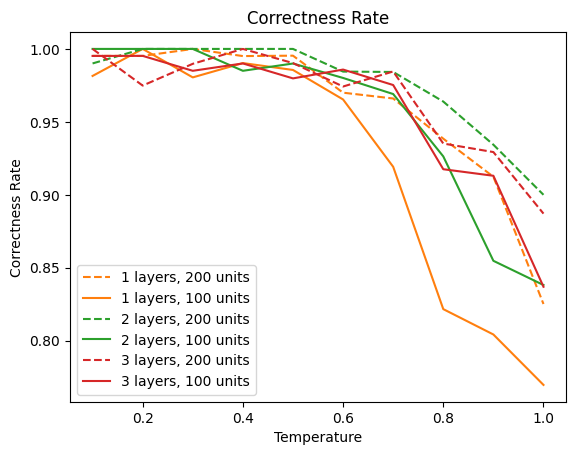

In [26]:
plt.figure()
plt.title('Correctness Rate')
plt.xlabel('Temperature')
plt.ylabel('Correctness Rate')

linestyle = ['solid', 'dashed']

for i in num_layers:
    for j in hidden_size:
        corr_rates = []      # Stores the values of the correctness rate for the current model
        for t in temperature:
            corr_rates.append(correctness_rate(i, j, 1000, t))
        
        # Plots the correctness rates as a function of the temperature
        plt.plot(temperature, corr_rates, color =f'C{i}', linestyle = linestyle[int(j/100 -1)], 
                 label=f'{i} layers, {j} units')     

plt.legend()
plt.show()

# Best Model Performance

Let's generate some reviews using the best performing model, according to out metric: 2 layers and 100 units.

In [44]:
for t in temperature:
    print(generate(start_string=' ', out_len=100, temperature=t, rnn_units=100, num_layers=2), '\n')

 ok and we were a seat and the flight was a seat and they were not a seat and they were a seat and 

 the service was not a bag is not a seat and the flight was a seat and they could not serve a 

 where we had to make a flight was suppensing the plane was a seat and the crew is quite seat and a 

 LCYSD who did not drink any lomes was in the flight that we were used them and the seat is good and 

 KRAre that we were not amountery that they are offered be allowed still expected for a flight and 

 Aх NDEM-2070 day of 35 hind minimalchare, seats-we were because the service was inhorgation Chica 



Syntactically, the first lines contain pretty much only existing words, whereas the last ones have some wrong words in them (especially the last line).   
This confirms that the correctness rate decreases with higher temperatures.  
From a semantic point of view, all the sentences are rather nonsensical.  
More precisely, the words seem to be coherent only in the context of the 1-2 previous and  1-2 following ones, but not in the context of the whole phrase.

# Generation Using Promts

Now we can try generating complaints using a propmt, with the same model and different temperature values.

In [36]:
prompt = 'the flight'
print(generate(start_string=prompt, out_len=60, temperature=0.2, rnn_units=100, num_layers=2))
print(generate(start_string=prompt, out_len=60, temperature=0.8, rnn_units=100, num_layers=2))

the flight was a seat and the flight was a basic flight with the
the flight with them again. Indiderate to perfort completed the next


In [41]:
prompt = 'the airport'
print(generate(start_string=prompt, out_len=60, temperature=0.2, rnn_units=100, num_layers=2))
print(generate(start_string=prompt, out_len=60, temperature=0.8, rnn_units=100, num_layers=2))

the airport was served and the check in was served and they don't
the airport and hold because I would delay exserutions flying with The


In [38]:
prompt = 'the staff'
print(generate(start_string=prompt, out_len=60, temperature=0.2, rnn_units=100, num_layers=2))
print(generate(start_string=prompt, out_len=60, temperature=0.8, rnn_units=100, num_layers=2))

the staff was a bad for a service and the seats were not an only on
the staff. The flight from Bangkok for them. I flew the crew


In [39]:
prompt = 'i will not'
print(generate(start_string=prompt, out_len=60, temperature=0.2, rnn_units=100, num_layers=2))
print(generate(start_string=prompt, out_len=60, temperature=0.8, rnn_units=100, num_layers=2))

i will not fly with them and the flight was a bag in the airport and
i will not ave received on an attendants grough are not most overall


The propts are completed quite sensibly, using correct grammar for the lowest temperature.  
But after the first few words the context given by the prompt is complitely lost.  

# Conclusions

These models are able to generate syntactically correct texts but the semantic quality of the output is very poor.  
The benchmark I chose to select the best model takes into account only the syntactic accuracy and not the ability to generate coherent sentences.  
The training process takes a very long time (5-15 min/epoch, depending on the number of trainable parameters), so I wasn't able to try more hyperparameters combinations or more epochs.   
